In [8]:
# pip install PuLP==2.9.0
# pip install matplotlib==3.9.0
from pulp import *
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import matplotlib.dates as mdates

import warnings

# Suppress specific UserWarning from pulp
warnings.filterwarnings("ignore", message="Spaces are not permitted in the name. Converted to '_'")

# Single Location Schedule

In [33]:
# BUSINESS RULES

# Available employees
available_employees = ['Alice', 'Mark', 'Bob', 'Susan', 'Charlie']

# Required roles to cover across business 
roles = ['Cook', 'Receptionist', 'Waiter', 'Chef']

# Business opening days
business_opening_days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

# Business opening hours
business_opening_hours = {
    'Mon': {'Start': '08:00', 'End': '20:00'},
    'Tue': {'Start': '08:00', 'End': '20:00'},
    'Wed': {'Start': '08:00', 'End': '20:00'},
    'Thu': {'Start': '08:00', 'End': '20:00'},
    'Fri': {'Start': '08:00', 'End': '20:00'},
    'Sat': {'Start': '08:00', 'End': '20:00'},
    'Sun': {'Start': '08:00', 'End': '20:00'}
}

# Business locations
locations = ['London', 'Stockholm']

# Employee roles (each employee could have one more than a role (e.g., Head Chef, Cook))
employee_roles = {
    'Alice': ['Cook'],
    'Mark': ['Receptionist'],
    'Bob': ['Waiter'],
    'Susan': ['Chef'],
    'Charlie': ['Waiter']
}

# Employee available to work at locations 
employee_locations = {
    'Alice': 'London',
    'Mark': 'London',
    'Bob': 'London',
    'Susan': 'Stockholm',
    'Charlie': 'Stockholm'
}

# Hours required to be covered for each day by role
role_hours_required = {
    'Mon': {'Cook': 12, 'Receptionist': 12, 'Waiter': 12, 'Chef': 12},
    'Tue': {'Cook': 12, 'Receptionist': 12, 'Waiter': 12, 'Chef': 12},
    'Wed': {'Cook': 12, 'Receptionist': 12, 'Waiter': 12, 'Chef': 12},
    'Thu': {'Cook': 12, 'Receptionist': 12, 'Waiter': 12, 'Chef': 12},
    'Fri': {'Cook': 12, 'Receptionist': 12, 'Waiter': 12, 'Chef': 12},
    'Sat': {'Cook': 12, 'Receptionist': 12, 'Waiter': 12, 'Chef': 12},
    'Sun': {'Cook': 12, 'Receptionist': 12, 'Waiter': 12, 'Chef': 12}
}


# Employee working hours as per contract 
employee_contracted_hours = {
    'Alice': {'Mon': 8, 'Tue': 8, 'Wed': 8, 'Thu': 8, 'Fri': 8, 'Sat': 0, 'Sun': 0},
    'Mark': {'Mon': 8, 'Tue': 8, 'Wed': 8, 'Thu': 8, 'Fri': 8, 'Sat': 0, 'Sun': 0},
    'Bob': {'Mon': 8, 'Tue': 8, 'Wed': 8, 'Thu': 8, 'Fri': 8, 'Sat': 0, 'Sun': 0},
    'Susan': {'Mon': 8, 'Tue': 8, 'Wed': 8, 'Thu': 8, 'Fri': 8, 'Sat': 0, 'Sun': 0},
    'Charlie': {'Mon': 8, 'Tue': 8, 'Wed': 8, 'Thu': 8, 'Fri': 8, 'Sat': 0, 'Sun': 0},
}

# Scheduled bank holidays
holidays = ['2022-01-01', '2022-01-02', '2022-01-03', '2022-01-04', '2022-01-05', '2022-01-06', '2022-01-07']


# EMPLOYEE RULES

# Time off
time_off = {'Mon': {'Start': '08:00', 'End': '20:00'}}


# shift = ['morning', '']

In [10]:
def schedule(employees: list[str], 
             roles: list[str], 
             business_opening_days: list[str], 
             employee_roles: dict[str, list[str]], 
             role_hours_required: dict[str, dict[str, int]], 
             employee_contracted_hours: dict[str, dict[str, int]], 
             employee_locations: dict[str, str],
             location: str,
             business_hour_max: int = 12, 
             business_days_max: int = 7):
    
    """
    Schedules employees for different roles on various days while minimizing uncovered hours.
    
    Parameters:
    - employees (list of str): List of employee names.
    - roles (list of str): List of job roles.
    - business_opening_days (list of str): List of days to schedule.
    - employee_roles (dict of {str: list of str}): Mapping of employee names to their roles.
    - role_hours_required (dict of {str: dict of {str: int}}): Mapping of days to roles to required hours.
    - employee_contracted_hours (dict of {str: dict of {str: int}}): Mapping of employees to days to their contracted working hours.
    - employee_locations (dict of {str: str}): Mapping of employees to their work locations.
    - location (str): The location to schedule employees for.
    - business_hour_max (int, optional): Maximum hours any employee can work in a day. Default is 12.
    - business_days_max (int, optional): Maximum days an employee can work in a week. Default is 7.
    
    Returns:
    - schedule_results (dict of {str: dict of {str: dict of {str: int}}}): Scheduled hours for each employee, day, and role.
    - uncovered_results (dict of {str: dict of {str: int}}): Uncovered hours for each day and role.
    - total_uncovered (int): Total number of uncovered hours.
    """
    
    # Filter employees based on location
    available_employees = [e for e in employees if employee_locations[e] == location]

    # Initialize the model
    schedule_problem = LpProblem("Restaurant Employee Scheduling", LpMinimize)

    # Create decision variables for max hours "business_hour_max" worked by each employee in each role on each day
    x = LpVariable.dicts("work", 
                         ((e, r, d) for e in available_employees for r in roles for d in business_opening_days), 
                         lowBound=0, upBound=business_hour_max, cat='Integer')  

    # Binary variable to indicate if an employee works in a role on a given day
    y = LpVariable.dicts("working_day", 
                         ((e, r, d) for e in available_employees for r in roles for d in business_opening_days), 
                         cat='Binary')

    # Create variables for uncovered hours for each role
    uncovered_hours = LpVariable.dicts("uncovered", 
                                       ((r, d) for r in roles for d in business_opening_days), 
                                       lowBound=0, cat='Integer')

    # Objective function: Minimize the total number of uncovered role hours
    schedule_problem += lpSum([uncovered_hours[r, d] for r in roles for d in business_opening_days])

    # Constraints
    for d in business_opening_days:
        for r in roles:
            # Ensure the required role hours are covered or accounted as uncovered
            schedule_problem += lpSum([x[e, r, d] for e in available_employees if r in employee_roles[e]]) \
                  + uncovered_hours[r, d] == role_hours_required[d][r]  # Use == instead of >=

            # Ensure the total hours assigned do not exceed role_hours_required
            schedule_problem += lpSum([x[e, r, d] for e in available_employees if r in employee_roles[e]]) <= role_hours_required[d][r]

    for e in available_employees:
        for d in business_opening_days:
            # Use the daily maximum hours for each employee
            max_hours = employee_contracted_hours[e][d]

            # Ensure each employee works at most their maximum hours per day across all roles
            schedule_problem += lpSum([x[e, r, d] for r in roles]) <= max_hours

            for r in roles:
                # Link binary variable with hours worked (if working, y = 1; otherwise, y = 0)
                schedule_problem += x[e, r, d] <= y[e, r, d] * max_hours

        # Ensure each employee works at most "business_days_max" days per week
        schedule_problem += lpSum([y[e, r, d] for r in roles for d in business_opening_days]) <= business_days_max

    # Solve the model with verbose output turned off
    schedule_problem.solve(PULP_CBC_CMD(msg=False))

    # Prepare results
    schedule_results = {}
    uncovered_results = {}
    total_uncovered = 0

    for e in available_employees:
        schedule_results[e] = {}
        for d in business_opening_days:
            schedule_results[e][d] = {}
            for r in roles:
                hours = x[e, r, d].value()
                if hours > 0:
                    schedule_results[e][d][r] = hours

    for d in business_opening_days:
        uncovered_results[d] = {}
        for r in roles:
            uncovered = uncovered_hours[r, d].value()
            uncovered_results[d][r] = uncovered
            total_uncovered += uncovered

    return schedule_results, uncovered_results, total_uncovered

In [25]:
def multi_location_schedule(employees: list[str], 
             roles: list[str], 
             business_opening_days: list[str], 
             employee_roles: dict[str, list[str]], 
             role_hours_required: dict[str, dict[str, int]], 
             employee_contracted_hours: dict[str, dict[str, int]], 
             employee_locations: dict[str, str],
             location: str,
             business_hour_max: int = 12, 
             business_days_max: int = 7):
    """
    Schedules employees for different roles across multiple locations while ensuring that employees do not
    work in more than one location per day and do not exceed a certain number of working days per week.

    Parameters:
    - employees (list of str): List of employee names.
    - roles (list of str): List of roles.
    - business_opening_days (list of str): Days of the week the business operates.
    - locations (list of str): Locations where the business operates.
    - employee_roles (dict of {str: list of str}): Mapping of employee names to their possible roles.
    - role_hours_required (dict of {str: dict of {str: dict of int}}): Mapping of locations to days to roles to required hours.
    - employee_contracted_hours (dict of {str: dict of {str: int}}): Mapping of employees to their maximum work hours per day.
    - employee_locations (dict of {str: list of str}): Mapping of employees to a list of locations they can work at.
    - business_hour_max (int, optional): Maximum hours any employee can work in a day. Default is 12.
    - business_days_max (int, optional): Maximum number of days an employee can work in a week. Default is 5.
    
    Returns:
    - A tuple of dictionaries with schedule results, uncovered hours, and total uncovered hours.
    """

    # Initialize the problem
    problem = LpProblem("Multi-Location Employee Scheduling", LpMinimize)

    # Decision variables
    x = LpVariable.dicts("work_hours", (employees, roles, business_opening_days, locations), lowBound=0, upBound=business_hour_max, cat='Continuous')
    work = LpVariable.dicts("work", (employees, business_opening_days, locations), cat='Binary')
    days_worked = LpVariable.dicts("days_worked", (employees, business_opening_days), cat='Binary')

    # Objective: Minimize uncovered hours
    uncovered_hours = LpVariable.dicts("uncovered_hours", (roles, business_opening_days, locations), lowBound=0, cat='Continuous')
    problem += lpSum(uncovered_hours[r][d][l] for r in roles for d in business_opening_days for l in locations)

    # Constraints
    for d in business_opening_days:
        for l in locations:
            for r in roles:
                # Ensure required hours are covered or noted as uncovered
                problem += lpSum(x[e][r][d][l] for e in employees if r in employee_roles[e] and l in employee_locations[e]) + uncovered_hours[r][d][l] == role_hours_required[l][d][r]

    for e in employees:
        for d in business_opening_days:
            # Employee works at most in one location per day
            problem += lpSum(work[e][d][l] for l in locations if l in employee_locations[e]) == days_worked[e][d]
            for l in locations:
                if l in employee_locations[e]:
                    # Work hours linked to binary work variables
                    problem += lpSum(x[e][r][d][l] for r in roles if r in employee_roles[e]) <= work[e][d][l] * business_hour_max
                    problem += lpSum(x[e][r][d][l] for r in roles if r in employee_roles[e]) <= employee_contracted_hours[e][d]

        # Employee does not exceed maximum days per week
        problem += lpSum(days_worked[e][d] for d in business_opening_days) <= business_days_max

    # Solve the problem
    problem.solve(PULP_CBC_CMD(msg=False))

    # Extract and print results
    schedule_results = {e: {d: {l: {r: x[e][r][d][l].varValue for r in roles if x[e][r][d][l].varValue > 0} for l in locations} for d in business_opening_days} for e in employees}
    uncovered_results = {(r, d, l): uncovered_hours[r][d][l].varValue for r in roles for d in business_opening_days for l in locations if uncovered_hours[r][d][l].varValue > 0}
    total_uncovered = sum(uncovered_results.values())

    return schedule_results, uncovered_results, total_uncovered

In [11]:
def assign_working_hours(schedule_results, opening_hours, coverage_preference="start"):
    """
    Assigns working hours to employees based on the schedule results and business opening hours.
    
    Parameters:
    - schedule_results: dict
        The schedule results with hours each employee will work each day for each role.
    - opening_hours: dict
        The opening hours for each day.
    - coverage_preference: str, optional
        The preference for covering hours: "start", "middle", "end". Default is "start".
    
    Returns:
    - working_hours: dict
        Dictionary with employees' working hours assigned based on opening hours and coverage preference.
    """
    def format_time(time):
        return time.strftime('%H:%M')

    def calculate_working_hours(start_time, hours, preference):
        end_time = start_time + timedelta(hours=hours)
        return format_time(start_time), format_time(end_time)

    working_hours = {}

    for e in schedule_results:
        working_hours[e] = {}
        for d in schedule_results[e]:
            if d not in working_hours[e]:
                working_hours[e][d] = {}

            start_time = datetime.strptime(opening_hours[d]['Start'], '%H:%M')
            end_time = datetime.strptime(opening_hours[d]['End'], '%H:%M')
            business_duration = (end_time - start_time).total_seconds() / 3600

            for r in schedule_results[e][d]:
                hours = schedule_results[e][d][r]
                if hours <= 0:
                    continue

                if coverage_preference == "start":
                    start, end = calculate_working_hours(start_time, hours, "start")
                elif coverage_preference == "end":
                    start, end = calculate_working_hours(end_time - timedelta(hours=hours), hours, "end")
                elif coverage_preference == "middle":
                    middle_start = start_time + timedelta(hours=(business_duration - hours) / 2)
                    start, end = calculate_working_hours(middle_start, hours, "middle")
                else:
                    raise ValueError("Invalid coverage preference. Choose from 'start', 'middle', 'end'.")

                working_hours[e][d][r] = {
                    "Start": start,
                    "End": end
                }

    return working_hours

In [17]:
location = 'London'

# Call the function with the parameters
schedule_results, uncovered_results, total_uncovered = schedule(
                                    available_employees, 
                                    roles, 
                                    business_opening_days, 
                                    employee_roles, 
                                    role_hours_required, 
                                    employee_contracted_hours, 
                                    employee_locations, 
                                    location = location,
)

In [18]:
# Print the schedule results
print("\nSchedule Results:")
for e in schedule_results:
    print(f"\nSchedule for {e}:")
    for d in schedule_results[e]:
        for r in schedule_results[e][d]:
            hours = schedule_results[e][d][r]
            print(f"  {d} - {r}: {hours} hours")


Schedule Results:

Schedule for Alice:
  Mon - Cook: 8.0 hours
  Tue - Cook: 8.0 hours
  Wed - Cook: 8.0 hours
  Thu - Cook: 8.0 hours
  Fri - Cook: 8.0 hours

Schedule for Mark:
  Mon - Receptionist: 8.0 hours
  Tue - Receptionist: 8.0 hours
  Wed - Receptionist: 8.0 hours
  Thu - Receptionist: 8.0 hours
  Fri - Receptionist: 8.0 hours

Schedule for Bob:
  Mon - Waiter: 8.0 hours
  Tue - Waiter: 8.0 hours
  Wed - Waiter: 8.0 hours
  Thu - Waiter: 8.0 hours
  Fri - Waiter: 8.0 hours


In [8]:
assign_working_hours(schedule_results, business_opening_hours, coverage_preference='end')

{'Alice': {'Mon': {'Cook': {'Start': '12:00', 'End': '20:00'}},
  'Tue': {'Cook': {'Start': '12:00', 'End': '20:00'}},
  'Wed': {'Cook': {'Start': '12:00', 'End': '20:00'}},
  'Thu': {'Cook': {'Start': '12:00', 'End': '20:00'}},
  'Fri': {'Cook': {'Start': '12:00', 'End': '20:00'}},
  'Sat': {},
  'Sun': {}},
 'Mark': {'Mon': {'Receptionist': {'Start': '12:00', 'End': '20:00'}},
  'Tue': {'Receptionist': {'Start': '12:00', 'End': '20:00'}},
  'Wed': {'Receptionist': {'Start': '12:00', 'End': '20:00'}},
  'Thu': {'Receptionist': {'Start': '12:00', 'End': '20:00'}},
  'Fri': {'Receptionist': {'Start': '12:00', 'End': '20:00'}},
  'Sat': {},
  'Sun': {}},
 'Bob': {'Mon': {'Waiter': {'Start': '16:00', 'End': '20:00'}},
  'Tue': {'Waiter': {'Start': '16:00', 'End': '20:00'}},
  'Wed': {'Waiter': {'Start': '16:00', 'End': '20:00'}},
  'Thu': {'Waiter': {'Start': '16:00', 'End': '20:00'}},
  'Fri': {'Waiter': {'Start': '16:00', 'End': '20:00'}},
  'Sat': {},
  'Sun': {}},
 'Susan': {'Mon': {'

In [9]:
# Print the uncovered hours
print("\nUncovered Hours:")
for d in uncovered_results:
    print(f"\nDay: {d}")
    for r in uncovered_results[d]:
        uncovered = uncovered_results[d][r]
        print(f"  {r}: {uncovered} hours uncovered")

print(f"\nTotal uncovered hours: {total_uncovered}")


Uncovered Hours:

Day: Mon
  Cook: 4.0 hours uncovered
  Receptionist: 4.0 hours uncovered
  Waiter: 0.0 hours uncovered
  Chef: 4.0 hours uncovered

Day: Tue
  Cook: 4.0 hours uncovered
  Receptionist: 4.0 hours uncovered
  Waiter: 0.0 hours uncovered
  Chef: 4.0 hours uncovered

Day: Wed
  Cook: 4.0 hours uncovered
  Receptionist: 4.0 hours uncovered
  Waiter: 0.0 hours uncovered
  Chef: 4.0 hours uncovered

Day: Thu
  Cook: 4.0 hours uncovered
  Receptionist: 4.0 hours uncovered
  Waiter: 0.0 hours uncovered
  Chef: 4.0 hours uncovered

Day: Fri
  Cook: 4.0 hours uncovered
  Receptionist: 4.0 hours uncovered
  Waiter: 0.0 hours uncovered
  Chef: 4.0 hours uncovered

Day: Sat
  Cook: 12.0 hours uncovered
  Receptionist: 12.0 hours uncovered
  Waiter: 12.0 hours uncovered
  Chef: 12.0 hours uncovered

Day: Sun
  Cook: 12.0 hours uncovered
  Receptionist: 12.0 hours uncovered
  Waiter: 12.0 hours uncovered
  Chef: 12.0 hours uncovered

Total uncovered hours: 156.0


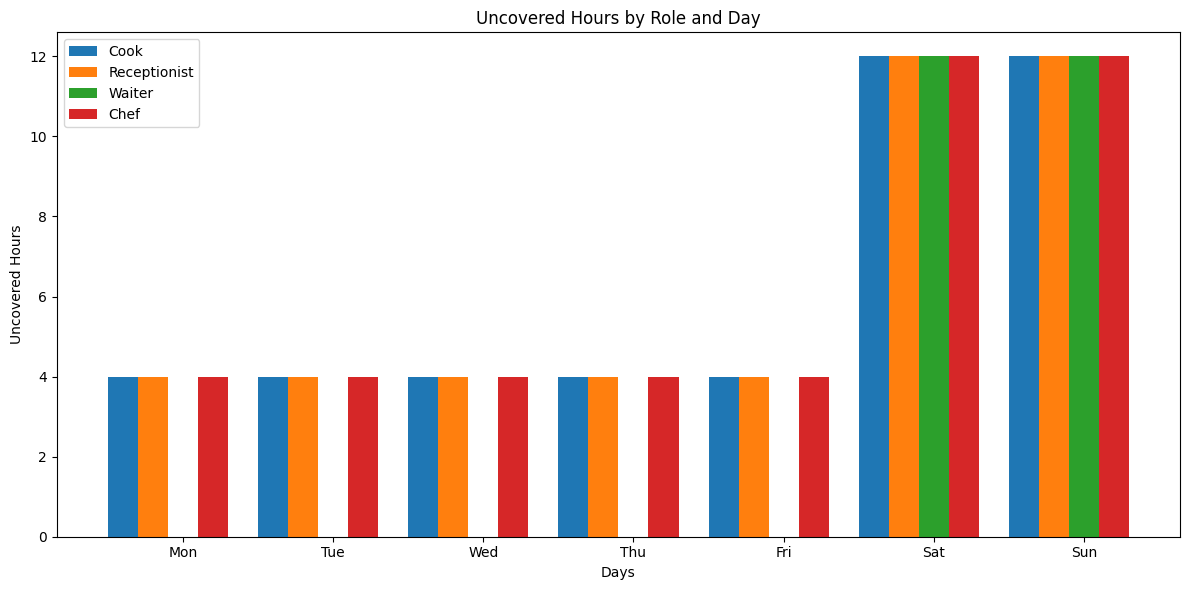

In [10]:
def plot_uncovered_hours(uncovered_results):
    # Prepare data for plotting
    days = list(uncovered_results.keys())
    roles = list(next(iter(uncovered_results.values())).keys())
    
    uncovered_data = {r: [uncovered_results[d][r] for d in days] for r in roles}
    
    # Create a plot
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Define bar width and positions
    bar_width = 0.2
    positions = [i for i in range(len(days))]
    
    # Plot each role's uncovered hours for each day
    for i, role in enumerate(roles):
        # Add bars for each role
        ax.bar([p + i * bar_width for p in positions], uncovered_data[role], bar_width, label=role)

    # Customize the plot
    ax.set_xlabel('Days')
    ax.set_ylabel('Uncovered Hours')
    ax.set_title('Uncovered Hours by Role and Day')
    ax.set_xticks([p + bar_width * (len(roles) / 2) for p in positions])
    ax.set_xticklabels(days)
    ax.legend()

    # Show the plot
    plt.tight_layout()
    plt.show()


# Plot the uncovered hours
plot_uncovered_hours(uncovered_results)

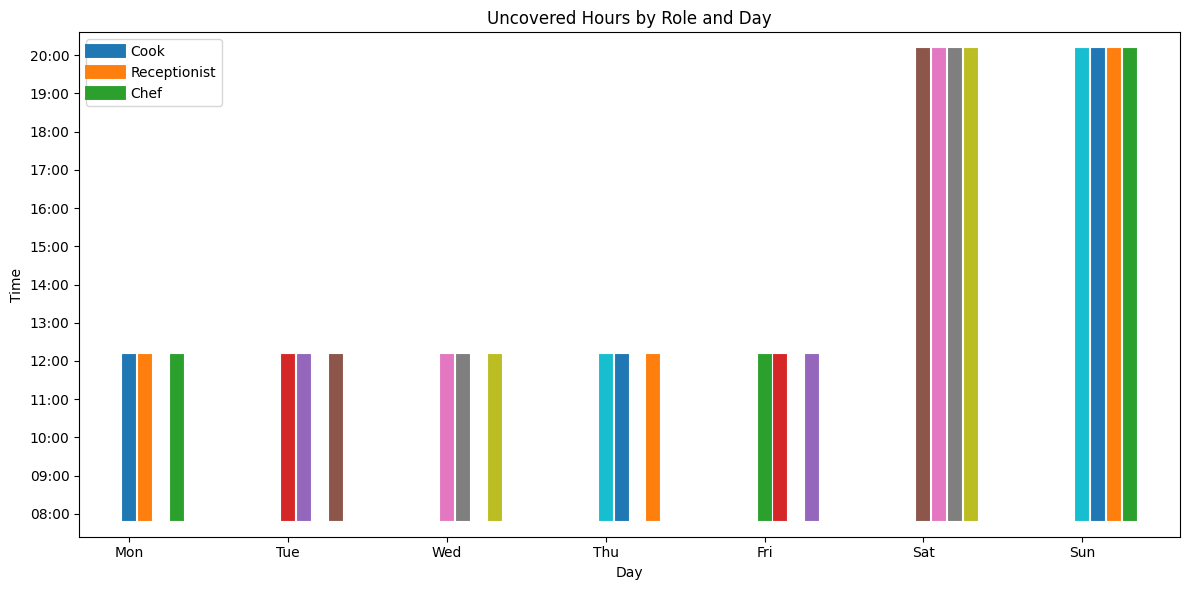

In [11]:
def plot_uncovered_hours_by_time(uncovered_results, opening_hours):
    # Prepare data for plotting
    days = list(uncovered_results.keys())
    roles = list(next(iter(uncovered_results.values())).keys())
    
    # Convert opening hours to datetime objects
    opening_times = {day: {'Start': datetime.strptime(oh['Start'], '%H:%M').time(),
                           'End': datetime.strptime(oh['End'], '%H:%M').time()}
                     for day, oh in opening_hours.items()}
    
    # Create a plot
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Loop through days and roles to plot uncovered hours
    for i, day in enumerate(days):
        day_start = datetime.combine(datetime.today(), opening_times[day]['Start'])
        day_end = datetime.combine(datetime.today(), opening_times[day]['End'])
        
        for j, role in enumerate(roles):
            uncovered_hours = uncovered_results[day][role]
            if uncovered_hours > 0:
                start_time = day_start
                end_time = start_time + timedelta(hours=uncovered_hours)
                
                # Adjust the x-position slightly for each role to avoid overlapping
                ax.plot([i + j*0.1, i + j*0.1], [start_time, end_time], label=role if i == 0 else "", linewidth=10)
    
    # Customize the plot
    ax.yaxis.set_major_locator(mdates.HourLocator(interval=1))
    ax.yaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax.set_xticks(range(len(days)))
    ax.set_xticklabels(days)
    ax.set_ylabel('Time')
    ax.set_xlabel('Day')
    ax.set_title('Uncovered Hours by Role and Day')
    
    # Adjust legend to show each role only once
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys())
    
    # Show the plot
    plt.tight_layout()
    plt.show()

plot_uncovered_hours_by_time(uncovered_results, business_opening_hours)

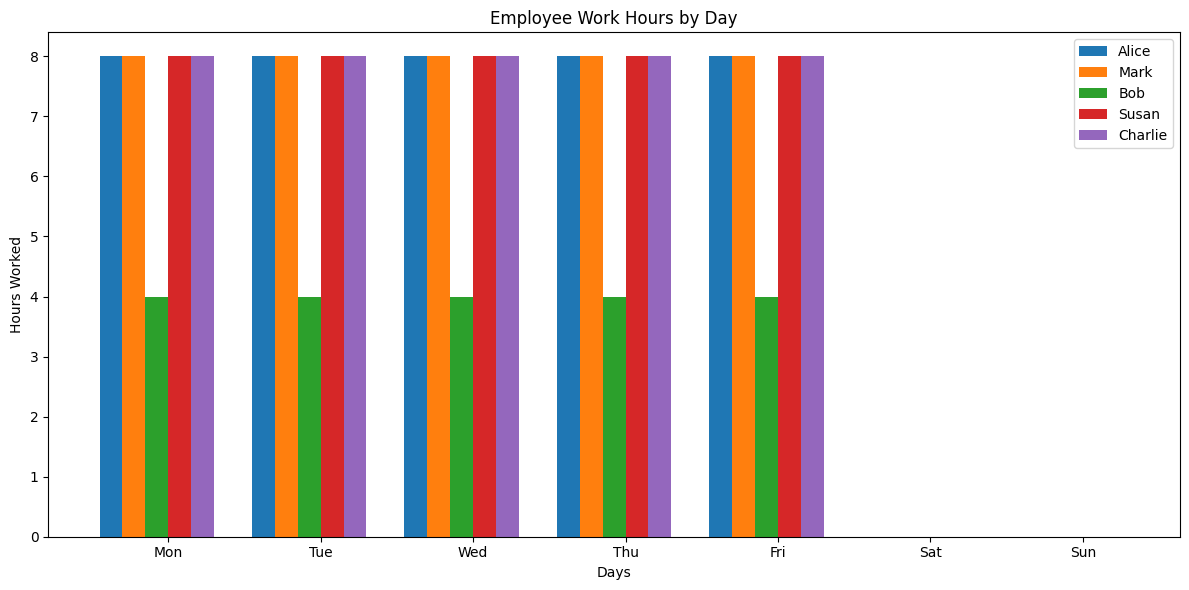

In [12]:
def plot_employee_work_hours(schedule_results):
    # Prepare data for plotting
    days = list(next(iter(schedule_results.values())).keys())
    employees = list(schedule_results.keys())
    
    # Calculate total hours worked by each employee each day
    employee_hours = {e: [sum(schedule_results[e][d].values()) for d in days] for e in employees}

    # Create a plot
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Define bar width and positions
    bar_width = 0.15
    positions = [i for i in range(len(days))]
    
    # Plot each employee's working hours for each day
    for i, employee in enumerate(employees):
        # Add bars for each employee
        ax.bar([p + i * bar_width for p in positions], employee_hours[employee], bar_width, label=employee)

    # Customize the plot
    ax.set_xlabel('Days')
    ax.set_ylabel('Hours Worked')
    ax.set_title('Employee Work Hours by Day')
    ax.set_xticks([p + bar_width * (len(employees) / 2) for p in positions])
    ax.set_xticklabels(days)
    ax.legend()

    # Show the plot
    plt.tight_layout()
    plt.show()

# Plot the employee work hours
plot_employee_work_hours(schedule_results)

# Multi Location Schedule

In [47]:
from pulp import LpProblem, LpMinimize, LpVariable, lpSum, PULP_CBC_CMD
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [42]:
# Define locations
locations = ['London', 'Stockholm']

# Define roles for each location
roles = {
    'London': ['Cook', 'Receptionist', 'Waiter'],
    'Stockholm': ['Chef', 'Waiter']
}

# Define business opening days for each location
business_opening_days = {
    'London': ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'],
    'Stockholm': ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sun']
}

# Define role hours required for each location
role_hours_required = {
    'London': {
        'Mon': {'Cook': 12, 'Receptionist': 12, 'Waiter': 12},
        'Tue': {'Cook': 12, 'Receptionist': 12, 'Waiter': 12},
        'Wed': {'Cook': 12, 'Receptionist': 12, 'Waiter': 12},
        'Thu': {'Cook': 12, 'Receptionist': 12, 'Waiter': 12},
        'Fri': {'Cook': 12, 'Receptionist': 12, 'Waiter': 12},
        'Sat': {'Cook': 12, 'Receptionist': 12, 'Waiter': 12}
    },
    'Stockholm': {
        'Mon': {'Chef': 12, 'Waiter': 12},
        'Tue': {'Chef': 12, 'Waiter': 12},
        'Wed': {'Chef': 12, 'Waiter': 12},
        'Thu': {'Chef': 12, 'Waiter': 12},
        'Fri': {'Chef': 12, 'Waiter': 12},
        'Sun': {'Chef': 12, 'Waiter': 12}
    }
}

# Define employee roles for each location
employee_roles = {
    'London': {
        'Alice': ['Cook'],
        'Mark': ['Receptionist'],
        'Bob': ['Waiter']
    },
    'Stockholm': {
        'Susan': ['Chef'],
        'Charlie': ['Waiter']
    }
}

# Define employee contracted hours for each location
employee_contracted_hours = {
    'London': {
        'Alice': {'Mon': 8, 'Tue': 8, 'Wed': 8, 'Thu': 8, 'Fri': 8, 'Sat': 0},
        'Mark': {'Mon': 8, 'Tue': 8, 'Wed': 8, 'Thu': 8, 'Fri': 8, 'Sat': 0},
        'Bob': {'Mon': 8, 'Tue': 8, 'Wed': 8, 'Thu': 8, 'Fri': 8, 'Sat': 0}
    },
    'Stockholm': {
        'Susan': {'Mon': 8, 'Tue': 8, 'Wed': 8, 'Thu': 8, 'Fri': 8, 'Sun': 0},
        'Charlie': {'Mon': 8, 'Tue': 8, 'Wed': 8, 'Thu': 8, 'Fri': 8, 'Sun': 0}
    }
}

# Define opening hours for each location
opening_hours = {
    'London': {
        'Mon': {'Start': '08:00', 'End': '20:00'},
        'Tue': {'Start': '08:00', 'End': '20:00'},
        'Wed': {'Start': '08:00', 'End': '20:00'},
        'Thu': {'Start': '08:00', 'End': '20:00'},
        'Fri': {'Start': '08:00', 'End': '20:00'},
        'Sat': {'Start': '08:00', 'End': '20:00'},
    },
    'Stockholm': {
        'Mon': {'Start': '09:00', 'End': '21:00'},
        'Tue': {'Start': '09:00', 'End': '21:00'},
        'Wed': {'Start': '09:00', 'End': '21:00'},
        'Thu': {'Start': '09:00', 'End': '21:00'},
        'Fri': {'Start': '09:00', 'End': '21:00'},
        'Sun': {'Start': '10:00', 'End': '22:00'}
    }
}

In [38]:

# Updated scheduling function
def multi_location_schedule(locations: list[str], 
                            business_opening_days: dict[str, list[str]], 
                            roles: dict[str, list[str]], 
                            role_hours_required: dict[str, dict[str, dict[str, int]]], 
                            employee_contracted_hours: dict[str, dict[str, dict[str, int]]], 
                            employee_roles: dict[str, dict[str, list[str]]],
                            business_hour_max: int = 12, 
                            business_days_max: int = 7):
    """
    Schedules employees for different roles on various days while minimizing uncovered hours for multiple locations.
    
    Parameters:
    - locations (list of str): List of business locations.
    - business_opening_days (dict of {str: list of str}): Mapping of locations to their opening days.
    - roles (dict of {str: list of str}): Mapping of locations to roles.
    - role_hours_required (dict of {str: dict of {str: dict of {str: int}}}): Mapping of locations to days to roles to required hours.
    - employee_contracted_hours (dict of {str: dict of {str: dict of {str: int}}}): Mapping of locations to employees to days to their contracted working hours.
    - employee_roles (dict of {str: dict of {str: list of str}}): Mapping of locations to employee names to their roles.
    - business_hour_max (int, optional): Maximum hours any employee can work in a day. Default is 12.
    - business_days_max (int, optional): Maximum days an employee can work in a week. Default is 7.
    
    Returns:
    - schedules (dict of {str: dict of {str: dict of {str: dict of {str: int}}}}): Scheduled hours for each location, employee, day, and role.
    - uncovered_results (dict of {str: dict of {str: dict of {str: int}}}): Uncovered hours for each location, day, and role.
    - total_uncovered (int): Total number of uncovered hours.
    """
    schedules = {}
    uncovered_results = {}
    total_uncovered = 0
    
    for location in locations:
        # Filter employees based on location
        available_employees = list(employee_roles[location].keys())
        
        # Initialize the model for each location
        schedule_problem = LpProblem(f"Employee Scheduling for {location}", LpMinimize)

        # Create decision variables for max hours "business_hour_max" worked by each employee in each role on each day
        x = LpVariable.dicts("work", 
                             ((e, r, d) for e in available_employees for r in roles[location] for d in business_opening_days[location]), 
                             lowBound=0, upBound=business_hour_max, cat='Integer')  

        # Binary variable to indicate if an employee works in a role on a given day
        y = LpVariable.dicts("working_day", 
                             ((e, d) for e in available_employees for d in business_opening_days[location]), 
                             cat='Binary')

        # Create variables for uncovered hours for each role
        uncovered_hours = LpVariable.dicts("uncovered", 
                                           ((r, d) for r in roles[location] for d in business_opening_days[location]), 
                                           lowBound=0, cat='Integer')

        # Objective function: Minimize the total number of uncovered role hours
        schedule_problem += lpSum([uncovered_hours[r, d] for r in roles[location] for d in business_opening_days[location]])

        # Constraints
        for d in business_opening_days[location]:
            for r in roles[location]:
                # Ensure the required role hours are covered or accounted as uncovered
                schedule_problem += lpSum([x[e, r, d] for e in available_employees if r in employee_roles[location][e]]) \
                      + uncovered_hours[r, d] == role_hours_required[location][d][r]

                # Ensure the total hours assigned do not exceed role_hours_required
                schedule_problem += lpSum([x[e, r, d] for e in available_employees if r in employee_roles[location][e]]) <= role_hours_required[location][d][r]

        for e in available_employees:
            for d in business_opening_days[location]:
                # Use the daily maximum hours for each employee
                max_hours = employee_contracted_hours[location][e][d]

                # Ensure each employee works at most their maximum hours per day across all roles
                schedule_problem += lpSum([x[e, r, d] for r in roles[location]]) <= max_hours

                for r in roles[location]:
                    # Link binary variable with hours worked (if working, y = 1; otherwise, y = 0)
                    schedule_problem += x[e, r, d] <= y[e, d] * max_hours

            # Ensure each employee works at most "business_days_max" days per week
            schedule_problem += lpSum([y[e, d] for d in business_opening_days[location]]) <= business_days_max

        # Solve the model with verbose output turned off
        schedule_problem.solve(PULP_CBC_CMD(msg=False))

        # Prepare results for each location
        schedules[location] = {}
        uncovered_results[location] = {}

        for e in available_employees:
            schedules[location][e] = {}
            for d in business_opening_days[location]:
                schedules[location][e][d] = {}
                for r in roles[location]:
                    hours = x[e, r, d].value()
                    if hours > 0:
                        schedules[location][e][d][r] = hours

        for d in business_opening_days[location]:
            uncovered_results[location][d] = {}
            for r in roles[location]:
                uncovered = uncovered_hours[r, d].value()
                uncovered_results[location][d][r] = uncovered
                total_uncovered += uncovered

    return schedules, uncovered_results, total_uncovered

# Run the scheduler for multiple locations
schedules, uncovered_results, total_uncovered = multi_location_schedule(
    locations,
    business_opening_days,
    roles,
    role_hours_required,
    employee_contracted_hours,
    employee_roles
)


In [39]:
# Extract and print the schedule results
print("\nSCHEDULE RESULTS:")
for location in schedules:
    print(f"\nLocation: {location}")
    for e in schedules[location]:
        print(f"  \nSchedule for {e}:")
        for d in schedules[location][e]:
            for r in schedules[location][e][d]:
                hours = schedules[location][e][d][r]
                print(f"    {d} - {r}: {hours} hours")



SCHEDULE RESULTS:

Location: London
  
Schedule for Alice:
    Mon - Cook: 8.0 hours
    Tue - Cook: 8.0 hours
    Wed - Cook: 8.0 hours
    Thu - Cook: 8.0 hours
    Fri - Cook: 8.0 hours
  
Schedule for Mark:
    Mon - Receptionist: 8.0 hours
    Tue - Receptionist: 8.0 hours
    Wed - Receptionist: 8.0 hours
    Thu - Receptionist: 8.0 hours
    Fri - Receptionist: 8.0 hours
  
Schedule for Bob:
    Mon - Waiter: 8.0 hours
    Tue - Waiter: 8.0 hours
    Wed - Waiter: 8.0 hours
    Thu - Waiter: 8.0 hours
    Fri - Waiter: 8.0 hours

Location: Stockholm
  
Schedule for Susan:
    Mon - Chef: 8.0 hours
    Tue - Chef: 8.0 hours
    Wed - Chef: 8.0 hours
    Thu - Chef: 8.0 hours
    Fri - Chef: 8.0 hours
  
Schedule for Charlie:
    Mon - Waiter: 8.0 hours
    Tue - Waiter: 8.0 hours
    Wed - Waiter: 8.0 hours
    Thu - Waiter: 8.0 hours
    Fri - Waiter: 8.0 hours


In [45]:
# Extract and print the uncovered hours
print("\nUNCOVERED HOURS:")
for location in uncovered_results:
    print(f"\nLocation: {location}")
    for d in uncovered_results[location]:
        print(f"\n  Day: {d}")
        for r in uncovered_results[location][d]:
            uncovered = uncovered_results[location][d][r]
            print(f"    {r}: {uncovered} hours uncovered")

# Print total uncovered hours
print(f"\nTotal uncovered hours: {total_uncovered}")


UNCOVERED HOURS:

Location: London

  Day: Mon
    Cook: 4.0 hours uncovered
    Receptionist: 4.0 hours uncovered
    Waiter: 4.0 hours uncovered

  Day: Tue
    Cook: 4.0 hours uncovered
    Receptionist: 4.0 hours uncovered
    Waiter: 4.0 hours uncovered

  Day: Wed
    Cook: 4.0 hours uncovered
    Receptionist: 4.0 hours uncovered
    Waiter: 4.0 hours uncovered

  Day: Thu
    Cook: 4.0 hours uncovered
    Receptionist: 4.0 hours uncovered
    Waiter: 4.0 hours uncovered

  Day: Fri
    Cook: 4.0 hours uncovered
    Receptionist: 4.0 hours uncovered
    Waiter: 4.0 hours uncovered

  Day: Sat
    Cook: 12.0 hours uncovered
    Receptionist: 12.0 hours uncovered
    Waiter: 12.0 hours uncovered

Location: Stockholm

  Day: Mon
    Chef: 4.0 hours uncovered
    Waiter: 4.0 hours uncovered

  Day: Tue
    Chef: 4.0 hours uncovered
    Waiter: 4.0 hours uncovered

  Day: Wed
    Chef: 4.0 hours uncovered
    Waiter: 4.0 hours uncovered

  Day: Thu
    Chef: 4.0 hours uncovered
    

In [44]:
def assign_working_hours(schedules, opening_hours, coverage_preference="start"):
    """
    Assigns working hours to employees based on the schedule results and business opening hours for each location.
    
    Parameters:
    - schedules: dict
        The schedule results with hours each employee will work each day for each role for each location.
    - opening_hours: dict
        The opening hours for each day for each location.
    - coverage_preference: str, optional
        The preference for covering hours: "start", "middle", "end". Default is "start".
    
    Returns:
    - working_hours: dict
        Dictionary with employees' working hours assigned based on opening hours and coverage preference for each location.
    """
    def format_time(time):
        return time.strftime('%H:%M')

    def calculate_working_hours(start_time, hours, preference):
        end_time = start_time + timedelta(hours=hours)
        return format_time(start_time), format_time(end_time)

    working_hours = {}

    for location in schedules:
        working_hours[location] = {}

        for e in schedules[location]:
            working_hours[location][e] = {}
            
            for d in schedules[location][e]:
                if d not in working_hours[location][e]:
                    working_hours[location][e][d] = {}

                # Get the opening and closing times for this location and day
                start_time = datetime.strptime(opening_hours[location][d]['Start'], '%H:%M')
                end_time = datetime.strptime(opening_hours[location][d]['End'], '%H:%M')
                business_duration = (end_time - start_time).total_seconds() / 3600

                for r in schedules[location][e][d]:
                    hours = schedules[location][e][d][r]
                    if hours <= 0:
                        continue

                    # Determine the start and end time based on coverage preference
                    if coverage_preference == "start":
                        start, end = calculate_working_hours(start_time, hours, "start")
                    elif coverage_preference == "end":
                        start, end = calculate_working_hours(end_time - timedelta(hours=hours), hours, "end")
                    elif coverage_preference == "middle":
                        middle_start = start_time + timedelta(hours=(business_duration - hours) / 2)
                        start, end = calculate_working_hours(middle_start, hours, "middle")
                    else:
                        raise ValueError("Invalid coverage preference. Choose from 'start', 'middle', 'end'.")

                    working_hours[location][e][d][r] = {
                        "Start": start,
                        "End": end
                    }

    return working_hours



# Run the assign working hours function
working_hours = assign_working_hours(schedules, opening_hours, coverage_preference="start")

# Extract and print the working hours
print("\nAssigned Working Hours:")
for location in working_hours:
    print(f"\nLocation: {location}")
    for e in working_hours[location]:
        print(f"\n  Working hours for {e}:")
        for d in working_hours[location][e]:
            for r in working_hours[location][e][d]:
                start = working_hours[location][e][d][r]["Start"]
                end = working_hours[location][e][d][r]["End"]
                print(f"    {d} - {r}: {start} to {end}")



Assigned Working Hours:

Location: London

  Working hours for Alice:
    Mon - Cook: 08:00 to 16:00
    Tue - Cook: 08:00 to 16:00
    Wed - Cook: 08:00 to 16:00
    Thu - Cook: 08:00 to 16:00
    Fri - Cook: 08:00 to 16:00

  Working hours for Mark:
    Mon - Receptionist: 08:00 to 16:00
    Tue - Receptionist: 08:00 to 16:00
    Wed - Receptionist: 08:00 to 16:00
    Thu - Receptionist: 08:00 to 16:00
    Fri - Receptionist: 08:00 to 16:00

  Working hours for Bob:
    Mon - Waiter: 08:00 to 16:00
    Tue - Waiter: 08:00 to 16:00
    Wed - Waiter: 08:00 to 16:00
    Thu - Waiter: 08:00 to 16:00
    Fri - Waiter: 08:00 to 16:00

Location: Stockholm

  Working hours for Susan:
    Mon - Chef: 09:00 to 17:00
    Tue - Chef: 09:00 to 17:00
    Wed - Chef: 09:00 to 17:00
    Thu - Chef: 09:00 to 17:00
    Fri - Chef: 09:00 to 17:00

  Working hours for Charlie:
    Mon - Waiter: 09:00 to 17:00
    Tue - Waiter: 09:00 to 17:00
    Wed - Waiter: 09:00 to 17:00
    Thu - Waiter: 09:00 to 1

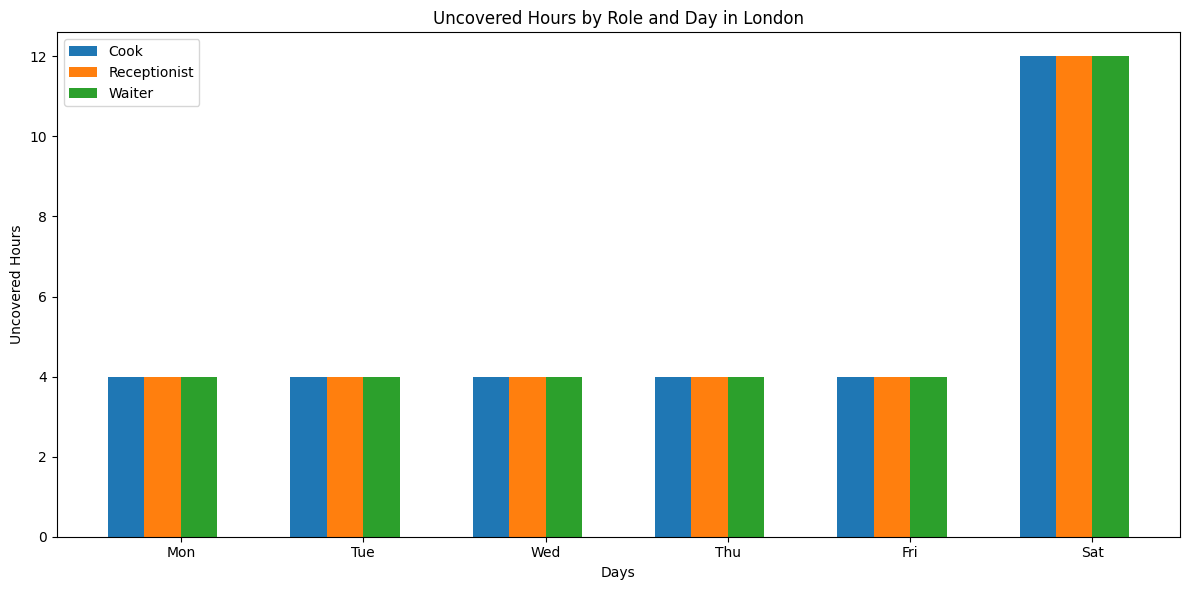

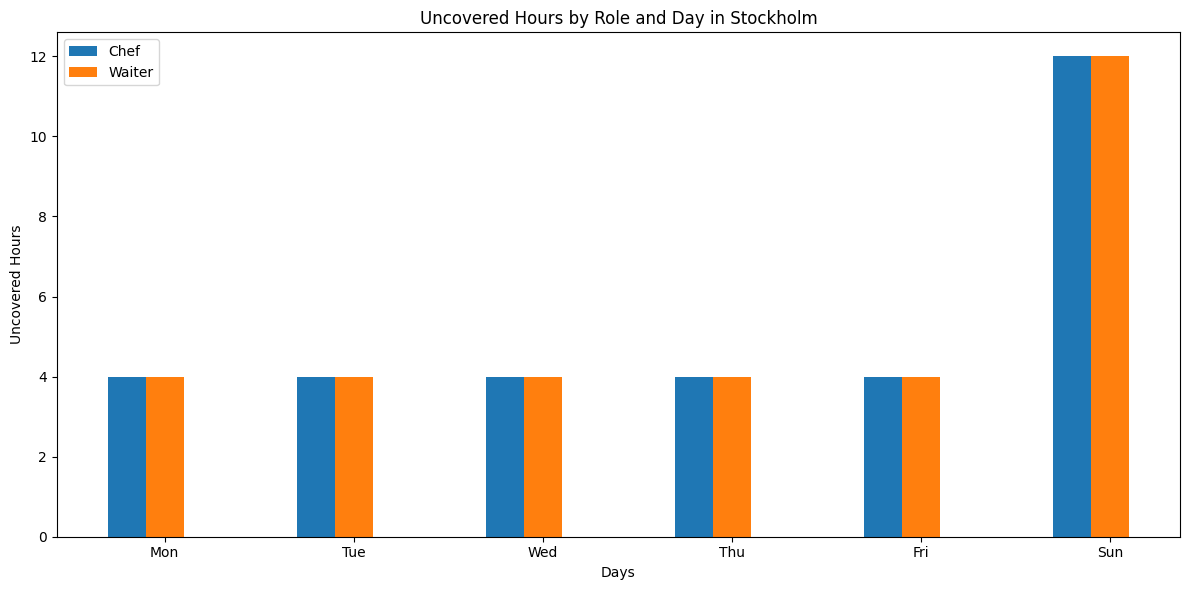

In [46]:
def plot_uncovered_hours(uncovered_results):
    """
    Plots uncovered hours by role and day for each location.

    Parameters:
    - uncovered_results: dict
        Dictionary containing uncovered hours for each location, day, and role.
    """
    for location, location_data in uncovered_results.items():
        # Prepare data for plotting
        days = list(location_data.keys())
        roles = list(next(iter(location_data.values())).keys())
        
        uncovered_data = {role: [location_data[day][role] for day in days] for role in roles}
        
        # Create a plot for each location
        fig, ax = plt.subplots(figsize=(12, 6))
        
        # Define bar width and positions
        bar_width = 0.2
        positions = [i for i in range(len(days))]
        
        # Plot each role's uncovered hours for each day
        for i, role in enumerate(roles):
            # Add bars for each role
            ax.bar([p + i * bar_width for p in positions], uncovered_data[role], bar_width, label=role)

        # Customize the plot
        ax.set_xlabel('Days')
        ax.set_ylabel('Uncovered Hours')
        ax.set_title(f'Uncovered Hours by Role and Day in {location}')
        ax.set_xticks([p + bar_width * (len(roles) / 2) for p in positions])
        ax.set_xticklabels(days)
        ax.legend()

        # Show the plot
        plt.tight_layout()
        plt.show()

# Plot the uncovered hours
plot_uncovered_hours(uncovered_results)

In [48]:
def plot_uncovered_hours_by_time(uncovered_results, opening_hours):
    """
    Plots uncovered hours by role and day for each location, showing specific time intervals.

    Parameters:
    - uncovered_results: dict
        Dictionary containing uncovered hours for each location, day, and role.
    - opening_hours: dict
        Dictionary with opening hours for each location and day.
    """
    for location, location_data in uncovered_results.items():
        # Prepare data for plotting
        days = list(location_data.keys())
        roles = list(next(iter(location_data.values())).keys())
        
        # Convert opening hours to datetime objects for the current location
        opening_times = {day: {'Start': datetime.strptime(opening_hours[location][day]['Start'], '%H:%M').time(),
                               'End': datetime.strptime(opening_hours[location][day]['End'], '%H:%M').time()}
                         for day in days}
        
        # Create a plot for each location
        fig, ax = plt.subplots(figsize=(12, 6))
        
        # Loop through days and roles to plot uncovered hours
        for i, day in enumerate(days):
            day_start = datetime.combine(datetime.today(), opening_times[day]['Start'])
            day_end = datetime.combine(datetime.today(), opening_times[day]['End'])
            
            for j, role in enumerate(roles):
                uncovered_hours = location_data[day][role]
                if uncovered_hours > 0:
                    start_time = day_start
                    end_time = start_time + timedelta(hours=uncovered_hours)
                    
                    # Adjust the x-position slightly for each role to avoid overlapping
                    ax.plot([i + j * 0.1, i + j * 0.1], [start_time, end_time], label=role if i == 0 else "", linewidth=10)

        # Customize the plot
        ax.yaxis.set_major_locator(mdates.HourLocator(interval=1))
        ax.yaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
        ax.set_xticks(range(len(days)))
        ax.set_xticklabels(days)
        ax.set_ylabel('Time')
        ax.set_xlabel('Day')
        ax.set_title(f'Uncovered Hours by Role and Day in {location}')
        
        # Adjust legend to show each role only once
        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        ax.legend(by_label.values(), by_label.keys())
        
        # Show the plot
        plt.tight_layout()
        plt.show()

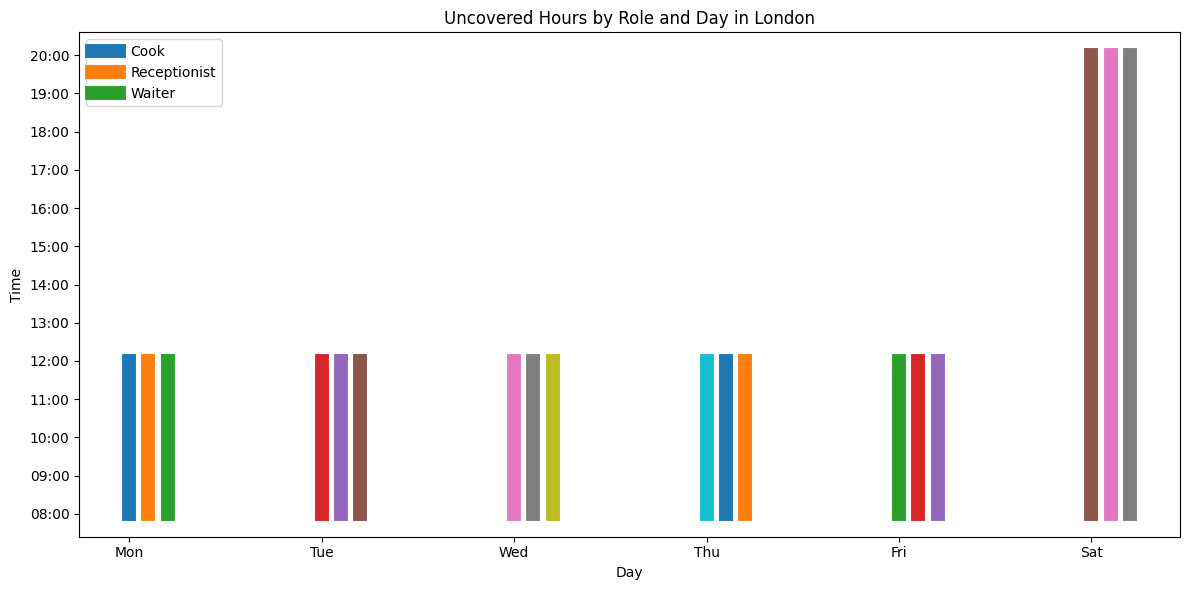

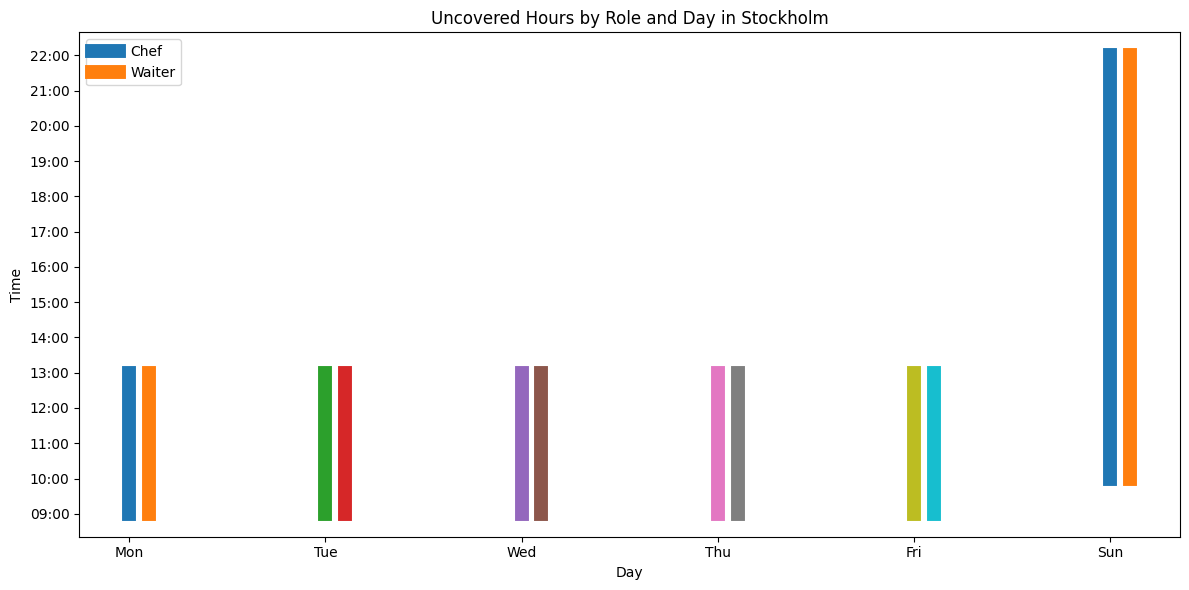

In [50]:
# Plot the uncovered hours by time
plot_uncovered_hours_by_time(uncovered_results, opening_hours)

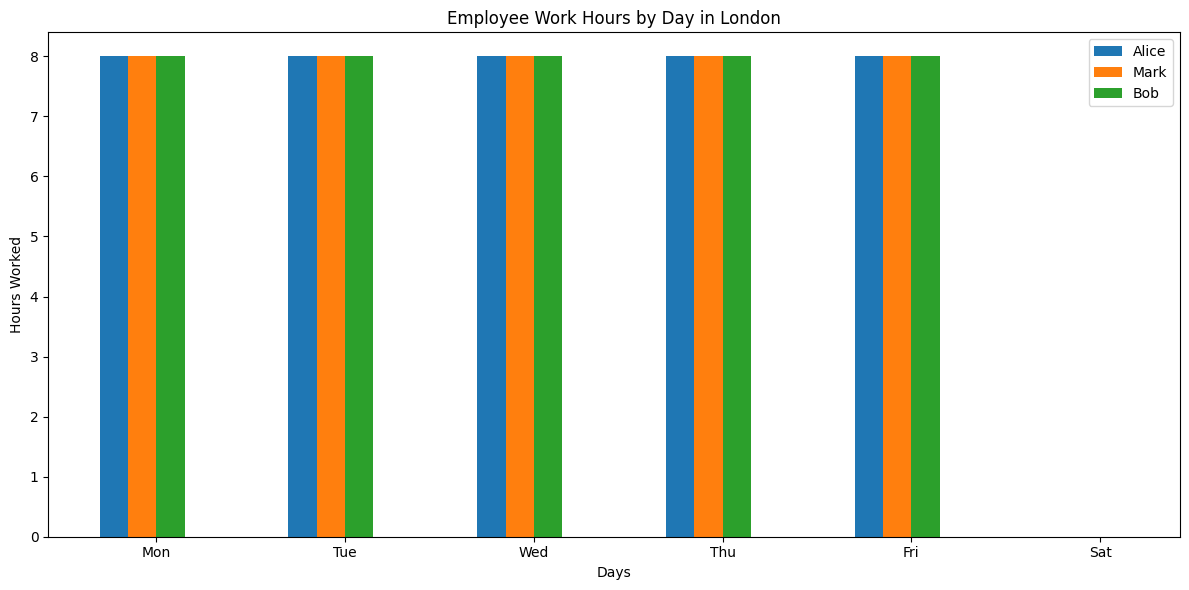

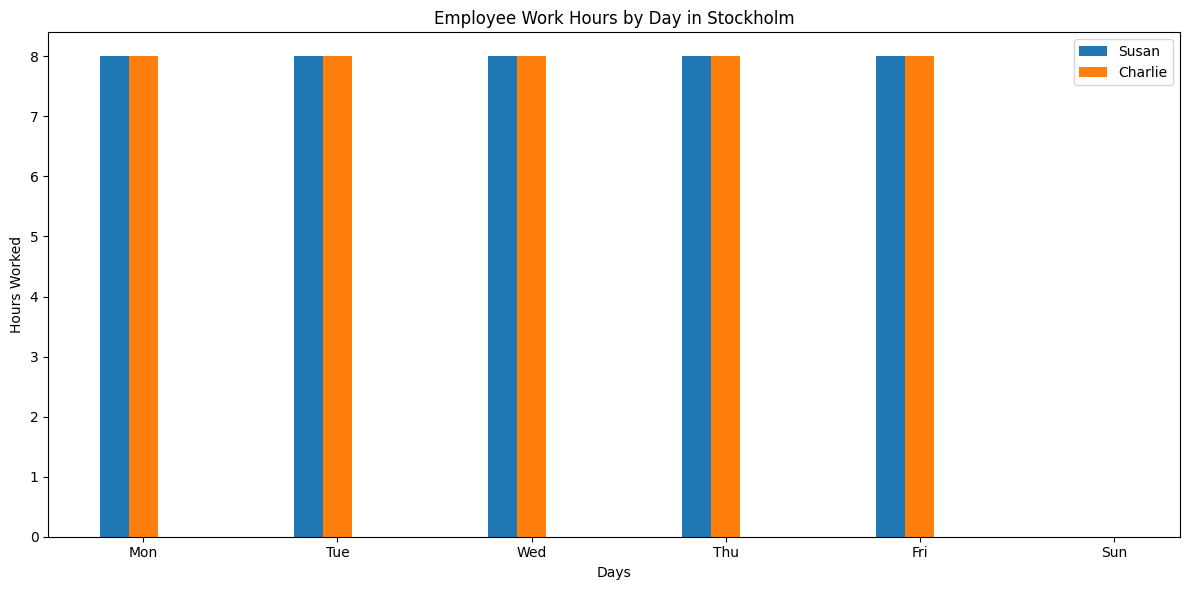

In [51]:
def plot_employee_work_hours(schedules):
    """
    Plots employee work hours by day for each location.

    Parameters:
    - schedules: dict
        Dictionary containing scheduled work hours for each location, employee, day, and role.
    """
    for location, location_data in schedules.items():
        # Prepare data for plotting
        days = list(next(iter(location_data.values())).keys())
        employees = list(location_data.keys())
        
        # Calculate total hours worked by each employee each day
        employee_hours = {
            e: [sum(location_data[e][d].values()) for d in days]
            for e in employees
        }

        # Create a plot for each location
        fig, ax = plt.subplots(figsize=(12, 6))
        
        # Define bar width and positions
        bar_width = 0.15
        positions = [i for i in range(len(days))]
        
        # Plot each employee's working hours for each day
        for i, employee in enumerate(employees):
            # Add bars for each employee
            ax.bar([p + i * bar_width for p in positions], employee_hours[employee], bar_width, label=employee)

        # Customize the plot
        ax.set_xlabel('Days')
        ax.set_ylabel('Hours Worked')
        ax.set_title(f'Employee Work Hours by Day in {location}')
        ax.set_xticks([p + bar_width * (len(employees) / 2) for p in positions])
        ax.set_xticklabels(days)
        ax.legend()

        # Show the plot
        plt.tight_layout()
        plt.show()

# Plot the employee work hours
plot_employee_work_hours(schedules)